# Quantitative Portfolio Construction and Risk Analysis

This Jupyter notebook demonstrates the construction of various investment portfolios using different strategies and performs risk analysis using Monte Carlo simulations. The project showcases skills in quantitative finance, coding, and time series analysis.


## Table of Contents

1. [Introduction](#introduction)
2. [Data Collection](#data-collection)
3. [Portfolio Construction](#portfolio-construction)
    - [Normal Portfolio](#normal-portfolio)
    - [Growth Portfolio](#growth-portfolio)
    - [Value Portfolio](#value-portfolio)
    - [Diversified Portfolio](#diversified-portfolio)
4. [Risk Analysis](#risk-analysis)
    - [Monte Carlo Simulation](#monte-carlo-simulation)
    - [Risk Metrics Calculation](#risk-metrics-calculation)
5. [Fund of Funds (FoF) Construction](#fund-of-funds-fof-construction)
6. [Conclusion](#conclusion)

## Introduction

In this project, we construct investment portfolios based on different strategies using data from the S&P 500 companies. We then perform risk analysis on these portfolios to understand their risk-return profiles. The main objectives are:

- **Portfolio Construction**: Build portfolios using various strategies (Normal, Growth, Value, Diversification) and different Assets Under Management (AUM) sizes (Small, Medium, Large).
- **Risk Analysis**: Calculate risk metrics such as Value at Risk (VaR), Expected Shortfall (ES), and volatility.
- **Optimization**: Use Monte Carlo simulations to optimize portfolio weights.
- **Fund of Funds (FoF)**: Combine individual portfolios into a FoF to achieve diversification benefits.

## Data Collection

We collect historical price and volume data for S&P 500 companies using the `yfinance` library. We also obtain sector information from Wikipedia.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import ssl
import certifi
import urllib.request
import os
import matplotlib.pyplot as plt

# Define the annual risk-free rate (e.g., 0.5%)
risk_free_rate = 0.005  # 0.5% annualized risk-free rate

### Fetching S&P 500 Tickers and Sector Information

In [2]:
# Configure SSL context to use certifi's certificate bundle
ssl_context = ssl.create_default_context(cafile=certifi.where())

# Set environment variable for requests (used by yfinance)
os.environ['REQUESTS_CA_BUNDLE'] = certifi.where()

# Fetch S&P 500 tickers from Wikipedia using the custom SSL context
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = urllib.request.urlopen(sp500_url, context=ssl_context)
html = response.read()

# Read the HTML tables from the content
sp500_table = pd.read_html(html)
sp500_df = sp500_table[0]

# Fix tickers with dots (e.g., BRK.B -> BRK-B)
sp500_df['Symbol'] = sp500_df['Symbol'].str.replace('.', '-', regex=False)

# Remove any duplicates or NaN values in the tickers
sp500_df = sp500_df.dropna(subset=['Symbol']).drop_duplicates(subset=['Symbol'])

# Convert tickers to a list
tickers = sp500_df['Symbol'].tolist()

# Remove problematic tickers manually (if known)
problematic_tickers = ['BF-B', 'BRK-B']
tickers = [ticker for ticker in tickers if ticker not in problematic_tickers]

# Print the number of tickers
print(f"Number of tickers to download: {len(tickers)}")

Number of tickers to download: 501


### Downloading Historical Data

In [3]:
# Download data for all tickers at once
print("Downloading data for all tickers...")
try:
    # Fetch 2 years of daily price data for each ticker
    data = yf.download(tickers, period='2y', interval='1d', group_by='ticker', threads=True)
except Exception as e:
    # Handle any errors during data download
    print(f"An error occurred while downloading data: {e}")
    data = pd.DataFrame()

# Check if the data DataFrame is empty
if data.empty:
    print("No data downloaded.")
else:
    # Prepare the data based on the type of column index
    if isinstance(data.columns, pd.MultiIndex):
        # Adjust for MultiIndex by selecting 'Adj Close' prices for each ticker
        data = data.stack(level=0)['Adj Close'].unstack()
    else:
        # If single-level columns, directly use 'Adj Close' prices
        data = data['Adj Close']

    # Drop tickers with all NaN values
    data = data.dropna(axis=1, how='all')

    # Filter out tickers with less than 126 data points (insufficient data)
    sufficient_data_tickers = [ticker for ticker in data.columns if data[ticker].dropna().shape[0] >= 126]
    data = data[sufficient_data_tickers]

    # Calculate daily returns by percentage change and drop NaN values
    daily_returns = data.pct_change().dropna()

    # Print dimensions of the cleaned data DataFrame
    print(f"The data DataFrame has {len(data)} rows and {len(data.columns)} columns (tickers).")

    # Calculate approximate 6-month total returns if sufficient data is available
    if len(data) >= 126:
        returns_6m = data.iloc[-1] / data.iloc[-126] - 1  # 126 trading days = 6 months approx.
        # Proceed with the rest of the calculations
    else:
        print("Not enough data to calculate 6-month returns.")

[*********************100%***********************]  501 of 501 completed

4 Failed downloads:
['SOLV', 'GEV']: YFInvalidPeriodError("%ticker%: Period '2y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', 'ytd', 'max']")
['AMTM']: YFInvalidPeriodError("%ticker%: Period '2y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', 'ytd', 'max']")
['SW']: YFInvalidPeriodError("%ticker%: Period '2y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']")


The data DataFrame has 503 rows and 497 columns (tickers).


/var/folders/v2/8z_znnr5791b52w_r0cvy7qh0000gn/T/ipykernel_7402/435915075.py:18: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data = data.stack(level=0)['Adj Close'].unstack()


### Get Returns, Price, Volume and Volatility

In [4]:
### Calculating Returns and Volatility
# Calculate 6-month total returns if there is sufficient data
if len(data) >= 126:
    returns_6m = data.iloc[-1] / data.iloc[-126] - 1  # Approximate 126 trading days in 6 months
else:
    print("Not enough data to calculate 6-month returns.")

# Download and isolate volume data for the past year
volume_data = yf.download(tickers, period='1y', interval='1d')['Volume']

# Calculate average trading volume over the last 6 months (126 trading days)
avg_volume_6m = volume_data.iloc[-126:].mean()

# Calculate 6-month volatilities based on the daily returns
volatility_6m = daily_returns.iloc[-126:].std()

# Retrieve the latest adjusted closing prices for each ticker
last_prices = data.iloc[-1]

[*********************100%***********************]  501 of 501 completed

2 Failed downloads:
['AMTM']: YFInvalidPeriodError("%ticker%: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', 'ytd', 'max']")
['SW']: YFInvalidPeriodError("%ticker%: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']")


### Creating Stock DataFrame

In [5]:
### Creating Stock DataFrame

# Get the union of all tickers from the three Series to ensure alignment
all_tickers = returns_6m.index.union(volatility_6m.index).union(avg_volume_6m.index)

# Reindex each Series to the common ticker index, filling missing values with NaN
returns_6m = returns_6m.reindex(all_tickers)
volatility_6m = volatility_6m.reindex(all_tickers)
avg_volume_6m = avg_volume_6m.reindex(all_tickers)

# Create a DataFrame containing stock data with key metrics
stock_data = pd.DataFrame({
    'Last_Prices': last_prices,
    '6M_Return': returns_6m,
    '6M_Volatility': volatility_6m,
    'Avg_Volume_6M': avg_volume_6m
})

# Reset index to make tickers a column in stock_data DataFrame
stock_data.reset_index(inplace=True)
stock_data.rename(columns={'index': 'Ticker'}, inplace=True)

# Merge stock_data with sector information from the S&P 500 DataFrame
stock_data = stock_data.merge(
    sp500_df[['Symbol', 'GICS Sector']],
    left_on='Ticker',
    right_on='Symbol',
    how='left'
)

# Remove the redundant 'Symbol' column after merging
stock_data.drop('Symbol', axis=1, inplace=True)

# Rename 'GICS Sector' column to 'Sector' for clarity
stock_data.rename(columns={'GICS Sector': 'Sector'}, inplace=True)

# Display the final stock_data DataFrame
stock_data

,Ticker,Last_Prices,6M_Return,6M_Volatility,Avg_Volume_6M,Sector
0,A,131.490005,-0.040549,0.016656,1.776121e+06,Health Care
1,AAPL,230.100006,0.333172,0.015724,5.860550e+07,Information Technology
2,ABBV,201.500000,0.274640,0.012961,5.089727e+06,Health Care
3,ABNB,136.500000,-0.137877,0.020973,4.345831e+06,Consumer Discretionary
4,ABT,114.449997,0.091384,0.011608,5.775939e+06,Health Care
...,...,...,...,...,...,...
496,XYL,130.220001,-0.037373,0.014040,1.185306e+06,Industrials
497,YUM,133.389999,-0.002633,0.010208,1.884436e+06,Consumer Discretionary
498,ZBH,109.809998,-0.068895,0.014664,1.503480e+06,Health Care
499,ZBRA,383.890015,0.227623,0.016284,3.397706e+05,Information Technology


## Portfolio Construction

We construct four types of portfolios based on different investment strategies, 20 stocks each:

1. **Normal Portfolio**: Top stocks by average trading volume.
2. **Growth Portfolio**: Top stocks by 6-month returns.
3. **Value Portfolio**: Top stocks with lowest 6-month volatility.
4. **Diversified Portfolio**: One stock from each sector.

We also define three AUM sizes:

- Small Portfolio: \$50 million
- Medium Portfolio: \$200 million
- Large Portfolio: \$1.5 billion

In [6]:
# Define Assets Under Management (AUM) values
aum_values = {
    'Small Portfolio': 50_000_000,
    'Medium Portfolio': 200_000_000,
    'Large Portfolio': 1_500_000_000
}

### Normal Portfolio

Select the top 20 stocks by average trading volume over the past 6 months.

In [7]:
# Select the top 20 stocks by average volume over the last 6 months
top_normal_stocks = stock_data.sort_values(by='Avg_Volume_6M', ascending=False).head(20)

# Create the normal portfolio DataFrame
normal_portfolio = top_normal_stocks.copy()

# Assign initial equal weights
normal_portfolio['Initial_Weight'] = 1 / len(normal_portfolio)

### Growth Portfolio

Select the top 20 stocks based on 6-month total returns.

In [8]:
# Select top 20 stocks sorted by highest 6-month returns
top_growth_stocks = stock_data.sort_values(by='6M_Return', ascending=False).head(20).copy()

# Calculate initial weights based on proportion of each stock's return to total return
top_growth_stocks['Initial_Weight'] = top_growth_stocks['6M_Return'] / top_growth_stocks['6M_Return'].sum()

### Value Portfolio

Select the top 20 stocks with the lowest 6-month volatility.

In [9]:
# Select top 20 stocks sorted by lowest 6-month volatility
top_value_stocks = stock_data.sort_values(by='6M_Volatility').head(20).copy()

# Calculate the inverse of volatility for weighting purposes
top_value_stocks['Inv_Volatility'] = 1 / top_value_stocks['6M_Volatility']

# Calculate initial weights based on inverse volatility proportions
top_value_stocks['Initial_Weight'] = top_value_stocks['Inv_Volatility'] / top_value_stocks['Inv_Volatility'].sum()

### Diversified Portfolio

Select one stock from each sector, prioritizing those with the highest 6-month returns within their sector.

In [10]:
## Get unique sectors present in the stock_data DataFrame
sectors = stock_data['Sector'].dropna().unique()

# Select one top-return stock per sector
selected_stocks = []
for sector in sectors:
    # Filter stocks within the current sector
    sector_stocks = stock_data[stock_data['Sector'] == sector]
    if not sector_stocks.empty:
        # Select the stock with the highest 6-month return in the sector
        stock = sector_stocks.sort_values(by='6M_Return', ascending=False).head(1)
        selected_stocks.append(stock)

# Concatenate selected stocks into a diversified portfolio
diversified_portfolio = pd.concat(selected_stocks)

# Add more high-return stocks until the portfolio has 20 stocks
while len(diversified_portfolio) < 20:
    remaining_stocks = stock_data[~stock_data['Ticker'].isin(diversified_portfolio['Ticker'])]
    # Select the next highest return stock not already in the portfolio
    next_stock = remaining_stocks.sort_values(by='6M_Return', ascending=False).head(1)
    diversified_portfolio = pd.concat([diversified_portfolio, next_stock])

# Set equal initial weights for all stocks in the diversified portfolio
diversified_portfolio['Initial_Weight'] = 1 / len(diversified_portfolio)

### Function to Process Portfolios

In [11]:
def process_portfolio(portfolio_df, last_prices, aum, strategy_name):
    """
    Process a portfolio by adjusting weights, capping, and calculating quantities based on AUM.

    Parameters:
    - portfolio_df: DataFrame containing portfolio tickers and initial weights.
    - last_prices: Series mapping tickers to their latest prices.
    - aum: Available capital (Assets Under Management) for allocation.
    - strategy_name: Name of the strategy for labeling purposes.

    Returns:
    - portfolio_df: Processed DataFrame with final weights, quantities, and financial allocations.
    """
    portfolio_df = portfolio_df.copy()
    
    # Map the latest price for each ticker
    portfolio_df['Price'] = portfolio_df['Ticker'].map(last_prices)
    
    # Remove rows with missing or zero prices
    portfolio_df = portfolio_df.dropna(subset=['Price'])
    portfolio_df = portfolio_df[portfolio_df['Price'] > 0]
    
    # Cap weights at a maximum of 10%
    portfolio_df['Capped_Weight'] = portfolio_df['Initial_Weight'].apply(lambda x: min(x, 0.10))
    
    # Calculate total of capped weights for redistribution check
    total_capped_weight = portfolio_df['Capped_Weight'].sum()
    if total_capped_weight == 0:
        raise ValueError(f"Total capped weight is zero for {strategy_name} strategy. Cannot proceed with weight redistribution.")
    elif total_capped_weight < 1.0:
        # Normalize if total capped weight is less than 1
        portfolio_df['Final_Weight'] = portfolio_df['Capped_Weight'] / total_capped_weight
    else:
        # Redistribute excess weight proportionally for capped weights below 10%
        excess_weight = portfolio_df['Initial_Weight'].sum() - portfolio_df['Capped_Weight'].sum()
        remaining_weight = portfolio_df['Capped_Weight'].sum()
        if remaining_weight == 0:
            raise ValueError(f"Remaining weight is zero for {strategy_name} strategy. Cannot redistribute excess weight.")
        portfolio_df['Final_Weight'] = portfolio_df.apply(
            lambda row: row['Capped_Weight'] + (excess_weight * row['Capped_Weight'] / remaining_weight)
            if row['Capped_Weight'] < 0.10 else row['Capped_Weight'], axis=1)
        # Normalize final weights
        portfolio_df['Final_Weight'] /= portfolio_df['Final_Weight'].sum()
    
    # Remove rows with NaN or zero in 'Final_Weight'
    portfolio_df = portfolio_df.dropna(subset=['Final_Weight'])
    portfolio_df = portfolio_df[portfolio_df['Final_Weight'] > 0]
    
    # Calculate 'Financial' allocation based on final weights and AUM
    portfolio_df['Financial'] = portfolio_df['Final_Weight'] * aum
    
    # Drop rows with NaN or zero in 'Financial' or 'Price' before calculating 'Quantity'
    portfolio_df = portfolio_df.dropna(subset=['Financial', 'Price'])
    portfolio_df = portfolio_df[(portfolio_df['Financial'] > 0) & (portfolio_df['Price'] > 0)]
    
    # Calculate 'Quantity' as an integer count of shares for each stock
    portfolio_df['Quantity'] = (portfolio_df['Financial'] // portfolio_df['Price']).astype(int)
    
    # Exclude rows where 'Quantity' is zero or negative
    portfolio_df = portfolio_df[portfolio_df['Quantity'] > 0]
    
    # Recalculate 'Financial' based on actual 'Quantity' and 'Price'
    portfolio_df['Financial'] = portfolio_df['Quantity'] * portfolio_df['Price']
    
    # Label portfolio with the strategy name
    portfolio_df['Strategy'] = strategy_name
    
    # Reorder columns for final output
    portfolio_df = portfolio_df[['Strategy', 'Ticker', 'Quantity', 'Price', 'Financial']]
    
    return portfolio_df

### Processing Portfolios for Each AUM Size

In [12]:
# Initialize an empty dictionary to store processed portfolios
portfolios = {}

# Loop through each AUM category to create portfolios
for aum_name, aum_value in aum_values.items():
    try:
        # Process Normal Portfolio for the current AUM
        portfolio_name = f"Normal_{aum_name.replace(' ', '_')}"
        processed_portfolio = process_portfolio(normal_portfolio, last_prices, aum_value, 'Normal')
        portfolios[portfolio_name] = processed_portfolio
        
        # Process Growth Portfolio for the current AUM
        portfolio_name = f"Growth_{aum_name.replace(' ', '_')}"
        processed_portfolio = process_portfolio(top_growth_stocks, last_prices, aum_value, 'Growth')
        portfolios[portfolio_name] = processed_portfolio
        
        # Process Value Portfolio for the current AUM
        portfolio_name = f"Value_{aum_name.replace(' ', '_')}"
        processed_portfolio = process_portfolio(top_value_stocks, last_prices, aum_value, 'Value')
        portfolios[portfolio_name] = processed_portfolio
        
        # Process Diversified Portfolio for the current AUM
        portfolio_name = f"Diversified_{aum_name.replace(' ', '_')}"
        processed_portfolio = process_portfolio(diversified_portfolio, last_prices, aum_value, 'Diversification')
        portfolios[portfolio_name] = processed_portfolio

    except Exception as e:
        # Print error if portfolio processing fails for a specific AUM
        print(f"Error processing portfolios for {aum_name}: {e}")

# Display example
portfolios['Diversified_Small_Portfolio']

,Strategy,Ticker,Quantity,Price,Financial
240,Diversification,INCY,33815,73.930000,2.499943e+06
374,Diversification,PLTR,57221,43.689999,2.499985e+06
80,Diversification,CCL,112815,22.160000,2.499980e+06
69,Diversification,BX,14573,171.539993,2.499852e+06
375,Diversification,PM,18923,132.110001,2.499918e+06
456,Diversification,UAL,31086,80.419998,2.499936e+06
474,Diversification,VST,20143,124.110001,2.499948e+06
244,Diversification,IP,50989,49.029999,2.499991e+06
248,Diversification,IRM,19586,127.639999,2.499957e+06
444,Diversification,TRGP,15003,166.630005,2.499950e+06


### Categorizing Portfolios

In [13]:
# Organize portfolios into categories
Categorized_Portfolios = {
    "Large": [
        ("Normal_Large_Portfolio", portfolios['Normal_Large_Portfolio']),
        ("Value_Large_Portfolio", portfolios['Value_Large_Portfolio']),
        ("Growth_Large_Portfolio", portfolios['Growth_Large_Portfolio']),
        ("Diversified_Large_Portfolio", portfolios['Diversified_Large_Portfolio'])
    ],
    "Medium": [
        ("Normal_Medium_Portfolio", portfolios['Normal_Medium_Portfolio']),
        ("Value_Medium_Portfolio", portfolios['Value_Medium_Portfolio']),
        ("Growth_Medium_Portfolio", portfolios['Growth_Medium_Portfolio']),
        ("Diversified_Medium_Portfolio", portfolios['Diversified_Medium_Portfolio'])
    ],
    "Small": [
        ("Normal_Small_Portfolio", portfolios['Normal_Small_Portfolio']),
        ("Value_Small_Portfolio", portfolios['Value_Small_Portfolio']),
        ("Growth_Small_Portfolio", portfolios['Growth_Small_Portfolio']),
        ("Diversified_Small_Portfolio", portfolios['Diversified_Small_Portfolio'])
    ]
}

## Risk Analysis

We perform risk analysis on the constructed portfolios using Monte Carlo simulations to optimize the portfolio weights and calculate risk metrics.

### Monte Carlo Simulation

In [14]:
def monte_carlo_simulation(returns, cov_matrix, num_simulations=10000):
    """
    Perform a Monte Carlo simulation to find the optimal portfolio weights
    that maximize the Sharpe ratio.

    Parameters:
    - returns: Expected returns for each asset.
    - cov_matrix: Covariance matrix of asset returns.
    - num_simulations: Number of simulations to run (default is 10,000).

    Returns:
    - optimal_weights: Array of weights that yield the maximum Sharpe ratio.
    - results: Array containing portfolio returns, volatilities, and Sharpe ratios.
    """
    num_assets = len(returns)
    results = np.zeros((3, num_simulations))  # Initialize array to store results
    weights_record = []  # List to keep track of each simulation's weights
    
    for i in range(num_simulations):
        # Generate random weights for the assets and normalize them
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        weights_record.append(weights)
        
        # Calculate portfolio return and volatility
        portfolio_return = np.dot(weights, returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        # Calculate Sharpe ratio, handling division by zero
        sharpe_ratio = portfolio_return / portfolio_volatility if portfolio_volatility != 0 else 0
        
        # Store the results for this simulation
        results[0, i] = portfolio_return
        results[1, i] = portfolio_volatility
        results[2, i] = sharpe_ratio
        
    # Identify the index of the highest Sharpe ratio
    max_sharpe_idx = np.argmax(results[2])
    # Retrieve weights that correspond to the maximum Sharpe ratio
    optimal_weights = weights_record[max_sharpe_idx]
    
    return optimal_weights, results

### Functions for Risk Calculations

In [15]:
def get_covariance_matrix(returns_df):
    """
    Calculate the covariance matrix for a DataFrame of asset returns.

    Parameters:
    - returns_df: DataFrame of asset returns.

    Returns:
    - Covariance matrix of the asset returns.
    """
    return returns_df.cov()

def calculate_daily_returns_portfolio(portfolio_df):
    """
    Extract daily returns for a given portfolio's tickers.

    Parameters:
    - portfolio_df: DataFrame with a column 'Ticker' listing portfolio tickers.

    Returns:
    - DataFrame of daily returns for the portfolio's valid tickers.
    """
    tickers = portfolio_df['Ticker'].tolist()
    # Filter to include only tickers present in daily_returns
    valid_tickers = [ticker for ticker in tickers if ticker in daily_returns.columns]
    portfolio_returns = daily_returns[valid_tickers]
    return portfolio_returns

def calculate_var_es(daily_returns, weights, confidence_level=0.95):
    """
    Calculate Value at Risk (VaR) and Expected Shortfall (ES) for a portfolio.

    Parameters:
    - daily_returns: DataFrame of daily returns.
    - weights: Array of portfolio weights.
    - confidence_level: Confidence level for VaR (default is 0.95).

    Returns:
    - var: Value at Risk at the specified confidence level.
    - es: Expected Shortfall at the specified confidence level.
    """
    # Calculate portfolio returns using the weights
    portfolio_returns = daily_returns.dot(weights)
    # Sort returns to find the VaR threshold
    sorted_returns = np.sort(portfolio_returns)
    index = int((1 - confidence_level) * len(sorted_returns))
    var = sorted_returns[index]
    es = sorted_returns[:index].mean()
    return var, es

def calculate_sharpe_ratio(returns, risk_free_rate=0.005):
    """
    Calculate the Sharpe ratio for a series of returns.

    Parameters:
    - returns: Series of returns.
    - risk_free_rate: Annual risk-free rate (default is 0.005).

    Returns:
    - sharpe_ratio: Sharpe ratio of the returns.
    """
    daily_risk_free_rate = risk_free_rate / 252  # Convert annual to daily rate
    excess_returns = returns - daily_risk_free_rate
    avg_excess_return = excess_returns.mean()
    std_excess_return = excess_returns.std()
    sharpe_ratio = avg_excess_return / std_excess_return if std_excess_return != 0 else 0
    return sharpe_ratio

def calculate_sortino_ratio(returns, risk_free_rate=0.005):
    """
    Calculate the Sortino ratio for a series of returns.

    Parameters:
    - returns: Series of returns.
    - risk_free_rate: Annual risk-free rate (default is 0.005).

    Returns:
    - sortino_ratio: Sortino ratio of the returns.
    """
    daily_risk_free_rate = risk_free_rate / 252  # Convert annual to daily rate
    excess_returns = returns - daily_risk_free_rate
    negative_returns = excess_returns[excess_returns < 0]
    downside_std = negative_returns.std()
    avg_excess_return = excess_returns.mean()
    sortino_ratio = avg_excess_return / downside_std if downside_std != 0 else 0
    return sortino_ratio


### Calculating Expected Returns

In [16]:
# Calculate expected returns for each portfolio and store in a dictionary for monte carlo
expected_returns_dict = {}

# Loop through each category of portfolios
for category, portfolios_list in Categorized_Portfolios.items():
    expected_returns_dict[category] = {}
    # Loop through each portfolio within the category
    for portfolio_name, portfolio_df in portfolios_list:
        # Calculate daily returns for the portfolio and store in the dictionary
        expected_returns_dict[category][portfolio_name] = calculate_daily_returns_portfolio(portfolio_df)


### Performing Monte Carlo Simulations

In [17]:
# Perform Monte Carlo simulations for each portfolio and store results
monte_carlo_results = {}

# Loop through each portfolio category
for category, portfolios_list in Categorized_Portfolios.items():
    monte_carlo_results[category] = {}
    # Loop through each portfolio within the category
    for portfolio_name, portfolio_df in portfolios_list:
        # Get daily returns for the current portfolio
        daily_returns_portfolio = expected_returns_dict[category][portfolio_name]
        if daily_returns_portfolio.empty:
            continue  # Skip simulation if no valid returns available
        
        # Calculate mean returns and covariance matrix for Monte Carlo inputs
        returns_mean = daily_returns_portfolio.mean()
        cov_matrix = get_covariance_matrix(daily_returns_portfolio)
        
        # Run Monte Carlo simulation to get optimal weights and results
        optimal_weights, results = monte_carlo_simulation(returns_mean, cov_matrix)
        
        # Store the simulation outcomes in the results dictionary
        monte_carlo_results[category][portfolio_name] = {
            'optimal_weights': optimal_weights,
            'simulation_results': results
        }


### Storing New Daily Returns

In [18]:
# Collect the returns of each optimized portfolio
portfolio_returns_list = []
portfolio_names = []

for category in Categorized_Portfolios:
    for portfolio_name, portfolio_df in Categorized_Portfolios[category]:
        # Check if the portfolio has optimization results
        if portfolio_name not in monte_carlo_results[category]:
            continue  # Skip if no simulation results
        
        # Get the optimized weights
        optimal_weights = monte_carlo_results[category][portfolio_name]['optimal_weights']
        
        # Get the daily returns for the portfolio
        daily_returns_portfolio = expected_returns_dict[category][portfolio_name]
        
        # Check if optimal_weights and daily_returns_portfolio are valid
        if optimal_weights is None or daily_returns_portfolio.empty:
            continue
        
        # Calculate the portfolio's daily returns using the optimized weights
        weighted_daily_returns = daily_returns_portfolio.dot(optimal_weights)
        
        # Store the portfolio returns
        portfolio_returns_list.append(weighted_daily_returns)
        portfolio_names.append(portfolio_name)

# Create a DataFrame of portfolio returns
portfolio_returns_df = pd.concat(portfolio_returns_list, axis=1)
portfolio_returns_df.columns = portfolio_names

### Risk Metrics Calculation

In [19]:
### Risk Metrics Calculation
# Calculate risk metrics for each portfolio
portfolio_risk_metrics = {}

# Loop through each portfolio category
for category, portfolios_list in Categorized_Portfolios.items():
    portfolio_risk_metrics[category] = {}
    # Loop through each portfolio within the category
    for portfolio_name, portfolio_df in portfolios_list:
        if portfolio_name not in monte_carlo_results[category]:
            continue  # Skip if no simulation results available
        
        # Retrieve daily returns and optimal weights for the portfolio
        daily_returns_portfolio = expected_returns_dict[category][portfolio_name]
        optimal_weights = monte_carlo_results[category][portfolio_name]['optimal_weights']
        
        # Calculate weighted daily returns based on optimal weights
        weighted_daily_returns = daily_returns_portfolio.dot(optimal_weights)
        
        # Calculate risk metrics
        var, es = calculate_var_es(daily_returns_portfolio, optimal_weights)
        volatility = weighted_daily_returns.std()
        sharpe_ratio = calculate_sharpe_ratio(weighted_daily_returns, risk_free_rate)
        sortino_ratio = calculate_sortino_ratio(weighted_daily_returns, risk_free_rate)
        
        # Store calculated metrics in the results dictionary
        portfolio_risk_metrics[category][portfolio_name] = {
            'VaR': var,
            'ES': es,
            'Volatility': volatility,
            'Sharpe_Ratio': sharpe_ratio,
            'Sortino_Ratio': sortino_ratio
        }

# Collect portfolio volatilities and names for further analysis
portfolio_volatilities = []
portfolio_names = []

for category in portfolio_risk_metrics:
    for portfolio_name in portfolio_risk_metrics[category]:
        volatility = portfolio_risk_metrics[category][portfolio_name]['Volatility']
        portfolio_volatilities.append(volatility)
        portfolio_names.append(portfolio_name)

# Convert portfolio volatilities to a NumPy array for further calculations
portfolio_volatilities = np.array(portfolio_volatilities)

# Print out the calculated risk metrics for each portfolio
for category in portfolio_risk_metrics:
    print(f"\nCategory: {category}")
    for portfolio_name in portfolio_risk_metrics[category]:
        metrics = portfolio_risk_metrics[category][portfolio_name]
        print(f"Portfolio: {portfolio_name}")
        print(f"  Sharpe Ratio: {metrics['Sharpe_Ratio']:.2f}")
        print(f"  Sortino Ratio: {metrics['Sortino_Ratio']:.2f}")
        print(f"  Volatility: {metrics['Volatility']:.2%}")
        print(f"  VaR: {metrics['VaR']:.2%}")
        print(f"  ES: {metrics['ES']:.2%}")


Category: Large
Portfolio: Normal_Large_Portfolio
  Sharpe Ratio: 0.16
  Sortino Ratio: 0.24
  Volatility: 1.30%
  VaR: -1.99%
  ES: -2.74%
Portfolio: Value_Large_Portfolio
  Sharpe Ratio: 0.20
  Sortino Ratio: 0.32
  Volatility: 0.56%
  VaR: -0.78%
  ES: -1.08%
Portfolio: Growth_Large_Portfolio
  Sharpe Ratio: 0.27
  Sortino Ratio: 0.43
  Volatility: 1.13%
  VaR: -1.65%
  ES: -2.25%
Portfolio: Diversified_Large_Portfolio
  Sharpe Ratio: 0.30
  Sortino Ratio: 0.52
  Volatility: 0.97%
  VaR: -1.27%
  ES: -1.78%

Category: Medium
Portfolio: Normal_Medium_Portfolio
  Sharpe Ratio: 0.15
  Sortino Ratio: 0.23
  Volatility: 0.96%
  VaR: -1.55%
  ES: -2.03%
Portfolio: Value_Medium_Portfolio
  Sharpe Ratio: 0.20
  Sortino Ratio: 0.32
  Volatility: 0.57%
  VaR: -0.79%
  ES: -1.11%
Portfolio: Growth_Medium_Portfolio
  Sharpe Ratio: 0.27
  Sortino Ratio: 0.45
  Volatility: 1.12%
  VaR: -1.53%
  ES: -2.18%
Portfolio: Diversified_Medium_Portfolio
  Sharpe Ratio: 0.30
  Sortino Ratio: 0.49
  Volati

### Visualizing Sharpe and Sortino Ratios

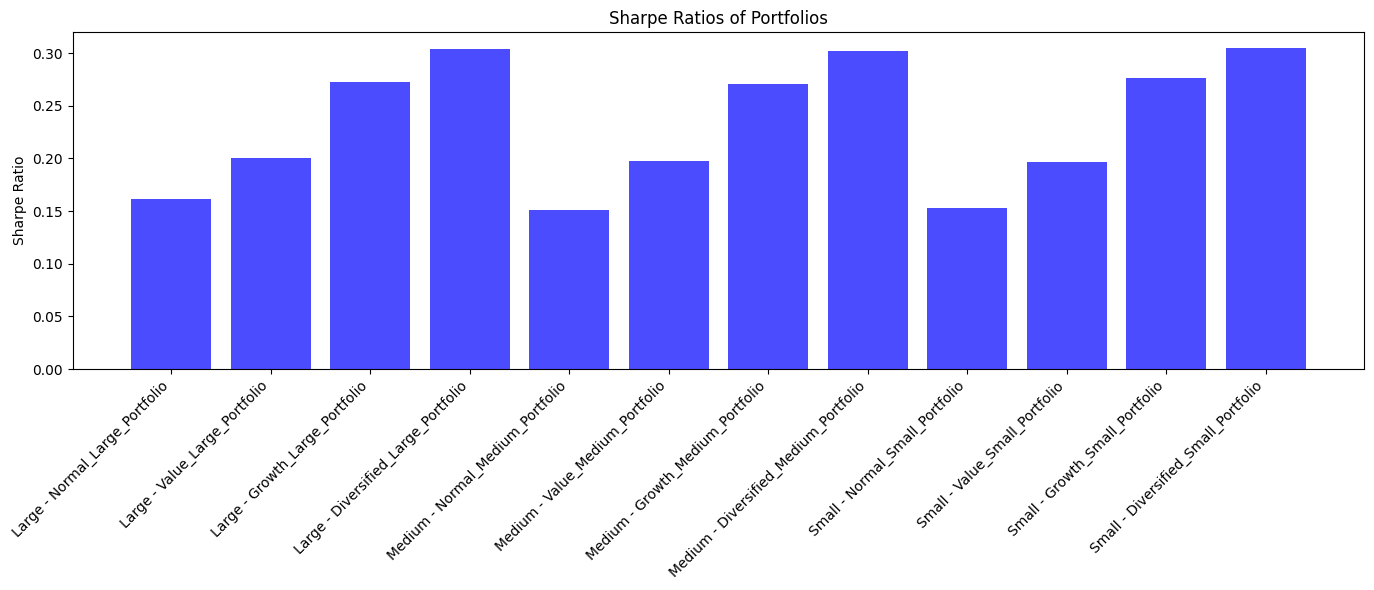

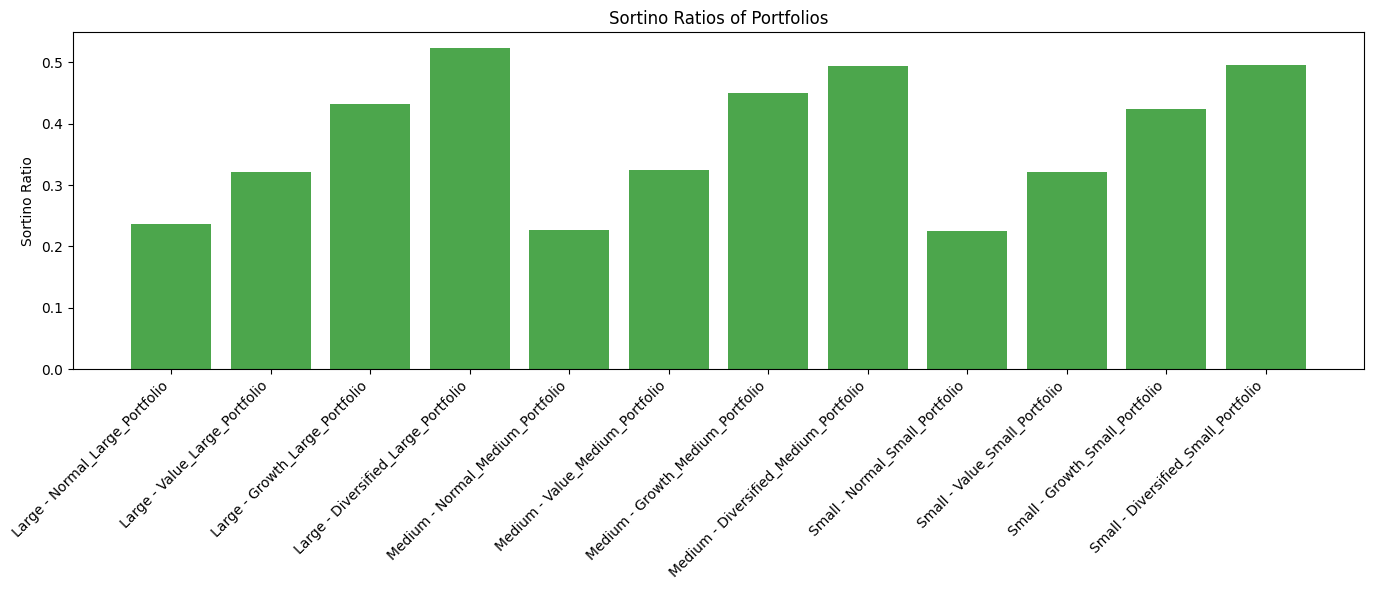

In [20]:
# Collect data for plotting
portfolios = []
sharpe_ratios = []
sortino_ratios = []

for category in portfolio_risk_metrics:
    for portfolio_name in portfolio_risk_metrics[category]:
        metrics = portfolio_risk_metrics[category][portfolio_name]
        portfolios.append(f"{category} - {portfolio_name}")
        sharpe_ratios.append(metrics['Sharpe_Ratio'])
        sortino_ratios.append(metrics['Sortino_Ratio'])

# Plot Sharpe Ratios
plt.figure(figsize=(14, 6))
plt.bar(portfolios, sharpe_ratios, color='blue', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratios of Portfolios')
plt.tight_layout()
plt.show()

# Plot Sortino Ratios
plt.figure(figsize=(14, 6))
plt.bar(portfolios, sortino_ratios, color='green', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Sortino Ratio')
plt.title('Sortino Ratios of Portfolios')
plt.tight_layout()
plt.show()

## Fund of Funds (FoF) Construction

We construct a Fund of Funds by combining individual portfolios based on their volatility.

### Calculating FoF Weights

In [21]:
def inverse_volatility_weights(volatilities):
    """
    Calculate inverse volatility weights without any maximum weight constraint.

    Parameters:
    - volatilities: numpy array of portfolio volatilities.

    Returns:
    - weights: numpy array of weights that are proportional to the inverse of volatilities.
    """
    # Calculate the inverse of each volatility value
    inv_vols = 1 / volatilities
    # Normalize to ensure weights sum to 1
    weights = inv_vols / np.sum(inv_vols)
    return weights


def inverse_volatility_weights_with_constraint(volatilities, max_weight=0.10):
    """
    Calculate inverse volatility weights with a maximum weight constraint.

    Parameters:
    - volatilities: numpy array of portfolio volatilities.
    - max_weight: maximum allowable weight for any portfolio.

    Returns:
    - weights: numpy array of adjusted weights.
    """
    inv_vols = 1 / volatilities
    weights = inv_vols / np.sum(inv_vols)

    # Initialize variables for the iterative process
    weights = np.minimum(weights, max_weight)
    total_weight = np.sum(weights)
    iteration = 0
    max_iterations = 100  # Safety cap to prevent infinite loops

    # Iteratively redistribute excess weight
    while total_weight < 1.0 and iteration < max_iterations:
        # Calculate the weights below the maximum limit
        below_max = weights < max_weight
        # Calculate the total weight below the maximum limit
        total_below_max = np.sum(weights[below_max])
        # If no weights are below max, break to avoid division by zero
        if total_below_max == 0:
            break
        # Calculate the amount of weight to redistribute
        remaining_weight = 1.0 - total_weight
        # Redistribute the remaining weight proportionally
        redistribution = remaining_weight * (weights[below_max] / total_below_max)
        weights[below_max] += redistribution
        # Reapply the maximum weight constraint
        weights = np.minimum(weights, max_weight)
        total_weight = np.sum(weights)
        iteration += 1

    # Normalize the weights to sum to 1 (in case of rounding errors)
    weights /= np.sum(weights)

    return weights

### Simulating FoF Performance

In [22]:
def simulate_fof_performance(weights, portfolio_returns_df):
    """
    Simulate the Fund of Funds (FoF) performance by computing the weighted sum of portfolio returns.

    Parameters:
    - weights: NumPy array of portfolio weights.
    - portfolio_returns_df: DataFrame of portfolio daily returns, where each column is a portfolio.

    Returns:
    - fof_returns: Series of FoF daily returns.
    """
    # Ensure that the weights and portfolio returns align
    if len(weights) != portfolio_returns_df.shape[1]:
        raise ValueError("Number of weights must match the number of portfolios.")
    
    # Calculate the FoF returns
    fof_returns = portfolio_returns_df.dot(weights)
    return fof_returns

### Calculating FoF Risk Metrics

In [23]:
def calculate_var_es_fof(returns, confidence_level=0.95):
    """
    Calculate Value at Risk (VaR) and Expected Shortfall (ES) for a series of returns.

    Parameters:
    - returns: Series of portfolio returns.
    - confidence_level: Confidence level for VaR (default is 0.95).

    Returns:
    - var: Value at Risk at the specified confidence level.
    - es: Expected Shortfall at the specified confidence level.
    """
    if returns.empty:
        return np.nan, np.nan  # Return NaN if no returns are available
    
    # Sort returns to find the VaR threshold
    sorted_returns = np.sort(returns)
    index = int((1 - confidence_level) * len(sorted_returns))
    var = sorted_returns[index]
    es = sorted_returns[:index].mean()  # Average of returns below the VaR threshold
    return var, es


### Executing FoF Construction and Analysis

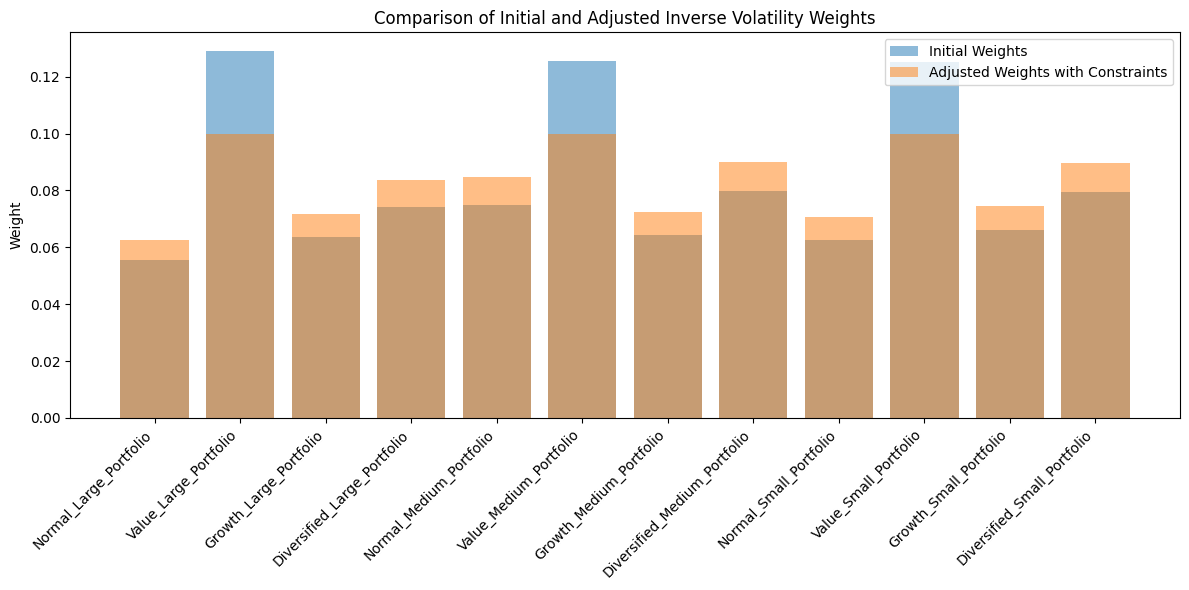


FoF with Inverse Volatility Weights:
VaR: -1.12%, ES: -1.47%
Volatility: 0.72%
Sharpe Ratio: 0.28
Sortino Ratio: 0.42

FoF with Adjusted Inverse Volatility Weights:
VaR: -1.17%, ES: -1.58%
Volatility: 0.77%
Sharpe Ratio: 0.28
Sortino Ratio: 0.42

Risk Contributions for adjusted:


,Portfolio,Weight,Risk Contribution,Percentage Risk Contribution
0,Normal_Large_Portfolio,0.062621,0.000685,0.089445
1,Value_Large_Portfolio,0.100000,0.000320,0.041750
2,Growth_Large_Portfolio,0.071798,0.000775,0.101201
3,Diversified_Large_Portfolio,0.083694,0.000763,0.099569
4,Normal_Medium_Portfolio,0.084618,0.000712,0.092926
5,Value_Medium_Portfolio,0.100000,0.000320,0.041745
6,Growth_Medium_Portfolio,0.072451,0.000752,0.098240
7,Diversified_Medium_Portfolio,0.089955,0.000763,0.099574
8,Normal_Small_Portfolio,0.070552,0.000713,0.093132
9,Value_Small_Portfolio,0.100000,0.000325,0.042404


In [24]:
# Ensure that portfolio_returns_df columns match the order of portfolio_names
portfolio_returns_df = portfolio_returns_df[portfolio_names]

# Calculate portfolio volatilities (standard deviations of returns)
portfolio_volatilities = np.array([portfolio_returns_df[portfolio].std() for portfolio in portfolio_names])

# Calculate FoF weights without constraints
fof_weights = inverse_volatility_weights(portfolio_volatilities)

# If you have a maximum weight constraint, you can apply it
max_weight = 0.10  # 10% maximum weight per portfolio
adjusted_weights = inverse_volatility_weights_with_constraint(portfolio_volatilities, max_weight)

# Create DataFrames of the weights
adjusted_weights_df = pd.DataFrame({
    'Portfolio': portfolio_names,
    'Adjusted Weight': adjusted_weights
})

fofWeights_df = pd.DataFrame({
    'Portfolio': portfolio_names,
    'Non-Adjusted Weight': fof_weights
})


# Plot initial inverse volatility weights vs. adjusted weights
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(portfolio_names, fof_weights, alpha=0.5, label='Initial Weights')
plt.bar(portfolio_names, adjusted_weights, alpha=0.5, label='Adjusted Weights with Constraints')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Weight')
plt.title('Comparison of Initial and Adjusted Inverse Volatility Weights')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate FoF returns using the updated simulate_fof_performance function
fof_returns = simulate_fof_performance(fof_weights, portfolio_returns_df)

# Calculate FoF risk metrics
fof_var, fof_es = calculate_var_es_fof(fof_returns)
fof_volatility = fof_returns.std()
fof_sharpe_ratio = calculate_sharpe_ratio(fof_returns, risk_free_rate)
fof_sortino_ratio = calculate_sortino_ratio(fof_returns, risk_free_rate)

# Print the results
print("\nFoF with Inverse Volatility Weights:")
print(f"VaR: {fof_var:.2%}, ES: {fof_es:.2%}")
print(f"Volatility: {fof_volatility:.2%}")
print(f"Sharpe Ratio: {fof_sharpe_ratio:.2f}")
print(f"Sortino Ratio: {fof_sortino_ratio:.2f}")

# Calculate the covariance matrix of portfolio returns
fof_cov_matrix = portfolio_returns_df.cov()

# The weights are already in fof_weights (a NumPy array)
inverse_vol_weights = fof_weights

# Calculate the FoF's total volatility
fof_volatility = np.sqrt(np.dot(inverse_vol_weights.T, np.dot(fof_cov_matrix.values, inverse_vol_weights)))

# Calculate marginal risk contribution of each portfolio
marginal_contributions = np.dot(fof_cov_matrix.values, inverse_vol_weights)

# Calculate total risk contribution of each portfolio
risk_contributions = inverse_vol_weights * marginal_contributions / fof_volatility

# Calculate percentage risk contributions
percentage_risk_contributions = risk_contributions / fof_volatility

# Optionally, print risk contributions
risk_contributions_df = pd.DataFrame({
    'Portfolio': portfolio_names,
    'Weight': inverse_vol_weights,
    'Risk Contribution': risk_contributions,
    'Percentage Risk Contribution': percentage_risk_contributions
})

# Calculate the FoF returns using the adjusted weights
fof_returns_adjusted = simulate_fof_performance(adjusted_weights, portfolio_returns_df)

# Calculate risk metrics for the adjusted FoF
fof_var_adj, fof_es_adj = calculate_var_es_fof(fof_returns_adjusted)
fof_volatility_adj = fof_returns_adjusted.std()
fof_sharpe_ratio_adj = calculate_sharpe_ratio(fof_returns_adjusted, risk_free_rate)
fof_sortino_ratio_adj = calculate_sortino_ratio(fof_returns_adjusted, risk_free_rate)

# Print the adjusted results
print("\nFoF with Adjusted Inverse Volatility Weights:")
print(f"VaR: {fof_var_adj:.2%}, ES: {fof_es_adj:.2%}")
print(f"Volatility: {fof_volatility_adj:.2%}")
print(f"Sharpe Ratio: {fof_sharpe_ratio_adj:.2f}")
print(f"Sortino Ratio: {fof_sortino_ratio_adj:.2f}")

# Calculate the covariance matrix of portfolio returns
fof_cov_matrix = portfolio_returns_df.cov()

# Use the adjusted weights (a NumPy array)
adjusted_inv_vol_weights = adjusted_weights

# Calculate the FoF's total volatility with adjusted weights
fof_volatility_adj = np.sqrt(np.dot(adjusted_inv_vol_weights.T, np.dot(fof_cov_matrix.values, adjusted_inv_vol_weights)))

# Calculate marginal risk contribution of each portfolio
marginal_contributions_adj = np.dot(fof_cov_matrix.values, adjusted_inv_vol_weights)

# Calculate total risk contribution of each portfolio
risk_contributions_adj = adjusted_inv_vol_weights * marginal_contributions_adj / fof_volatility_adj

# Calculate percentage risk contributions
percentage_risk_contributions_adj = risk_contributions_adj / fof_volatility_adj

# Optionally, print risk contributions
risk_contributions_adj_df = pd.DataFrame({
    'Portfolio': portfolio_names,
    'Weight': adjusted_inv_vol_weights,
    'Risk Contribution': risk_contributions_adj,
    'Percentage Risk Contribution': percentage_risk_contributions_adj
})

print("\nRisk Contributions for adjusted:")
risk_contributions_adj_df




## Conclusion

In this project, we successfully constructed and analyzed various investment portfolios using different strategies and AUM sizes. By performing risk analysis and optimization:

- **Portfolio Diversification**: We demonstrated the benefits of diversification through different strategies and the construction of a Fund of Funds.
- **Risk Management**: Calculated key risk metrics (VaR, ES, Volatility) and risk-adjusted performance metrics (Sharpe Ratio, Sortino Ratio) to understand the risk profile and performance of each portfolio.
- **Risk-Adjusted Performance**: The Sharpe and Sortino Ratios provided insights into how well each portfolio compensated investors for the risk taken, especially focusing on downside risk with the Sortino Ratio.
- **Optimization with Constraints**: Implemented a maximum weight constraint in the FoF construction to prevent over-concentration in any single portfolio, enhancing diversification and adhering to risk management practices.
- **Optimization**: Used Monte Carlo simulations and adjusted inverse volatility weighting to optimize portfolio weights, enhancing the risk-adjusted returns.

My analysis revealed that incorporating a maximum weight constraint in the FoF can lead to a more balanced portfolio allocation without significantly compromising performance. This highlights the importance of considering practical constraints in portfolio construction to manage risk effectively.

**Note**: The execution of this notebook may take some time due to data fetching and computations. Ensure you have a stable internet connection and the required packages installed.

**Packages Required**:

- pandas
- numpy
- yfinance
- matplotlib (optional for visualizations)